## Roll Simulation

Running a number of trials with exploding dice

Benchmark
numpy 1m trials (10d6) = 30s
numpy 10m ntrials (10d6) = x
cupy-rocm-5-0 1m trials (10d6) = ??
cupy-rocm-5-0 10m trials (10d6) = ??

In [45]:
import numpy as np

np.random.seed(1) # makes notebook repeatable

In [46]:
def simulate(
  max_dice = 10,
  trials = 4000000,
  faces = 6,
  explode_from = 6
):
  """
  returns np.ndarray with shape (explosions, trials, max_dice, max_dice)
  1st max dice is for each collection of dice rolled, from 1 to max_dice
  2nd max_dice is for each roll within collection (max_dice, max_dice) is triangular
  """
  rolls = []
  # since an np.ndarray must have constant dimensions,
  # we start by telling it to only keep some of the rolls based on how many dice in the collection
  # this is the same as saying in the prev roll only <collection size> dice exploded, so only count that many rolls
  keep = np.repeat([np.tri(max_dice)], trials, axis=0)

  while True:
      roll = np.random.randint(1, faces + 1, (trials, max_dice, max_dice), dtype=np.uint8) * keep
      keep = roll >= explode_from
      rolls.append(roll)
      if not np.any(keep):
        break

  return np.array(rolls, dtype=np.uint8)



In [47]:
%%script true # comment to run profiling

%reload_ext memory_profiler

for i in range(10):
  %memit -t 120 simulate(trials=1000000 * i)
  %timeit -n 1 -r 1 simulate(trials=1000000 * i)


In [48]:
max_dice = 10
trials = 1000000 # 4000000
faces = 6
explode_from = 6

rolls = simulate(max_dice=max_dice, trials=trials, faces=faces, explode_from=explode_from)

# Total Scores

For each trial sum all of the rolls

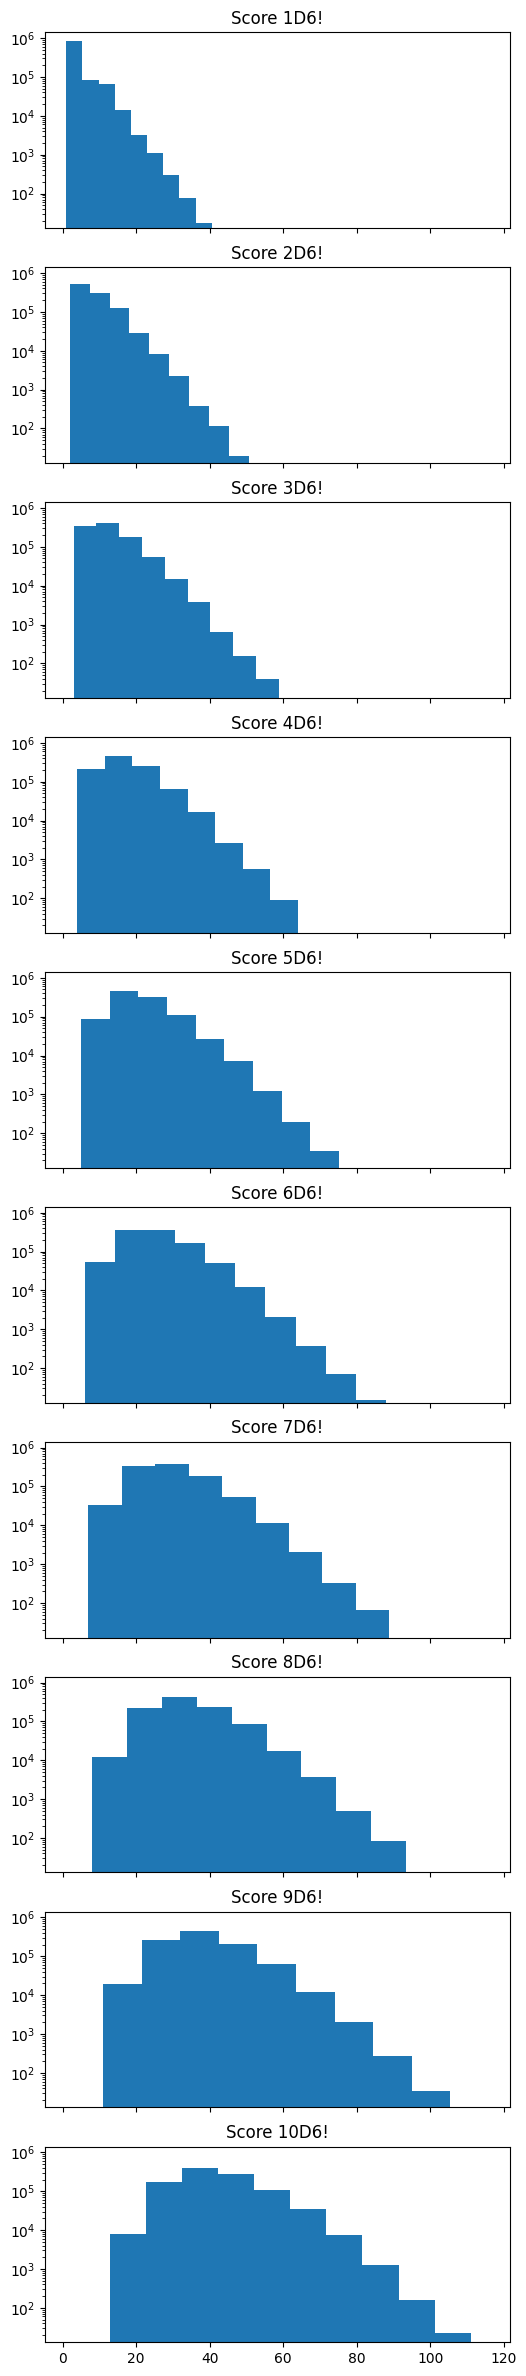

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=np.shape(rolls)[3], sharex=True, sharey=True)

fig.set_size_inches(6, 30)

for i, sum in enumerate(np.sum(rolls, axis=(0, 3)).T):
  ax[i].set_title(f"Score {i+1}D6!")
  ax[i].hist(sum)
  ax[i].set_yscale('log')

plt.show()

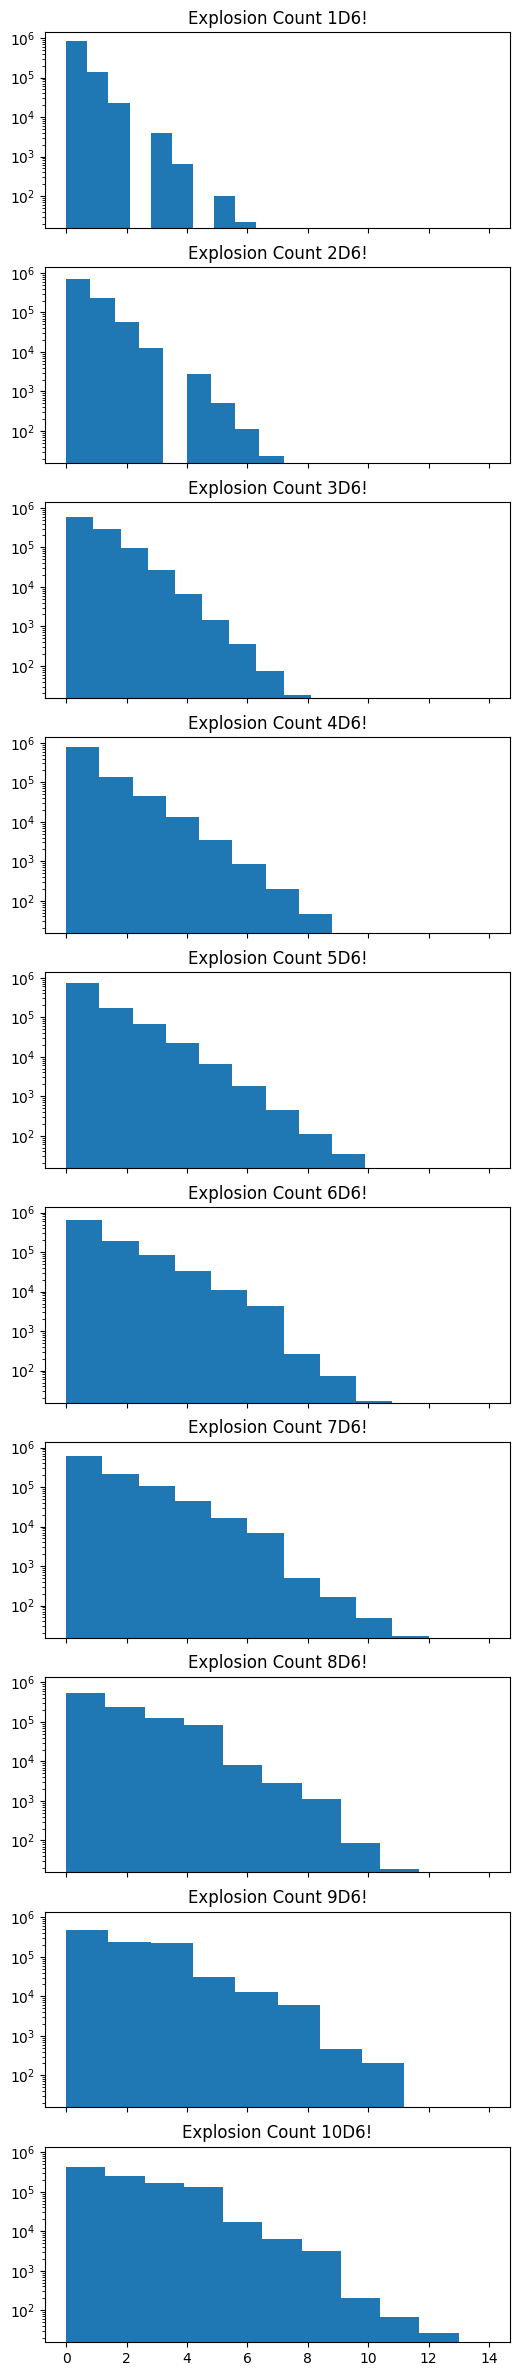

In [50]:
fig, ax = plt.subplots(nrows=np.shape(rolls)[3], sharex=True, sharey=True)

fig.set_size_inches(6, 30)
#fig.tight_layout(pad=5.0)

for i, count in enumerate(np.count_nonzero(rolls >= explode_from, axis=(0, 3)).T):
  ax[i].set_title(f"Explosion Count {i+1}D{faces}!")
  ax[i].hist(count)
  ax[i].set_yscale('log')

plt.show()

# 2 players

draws will go to the attacker (d&d style - meet to beat)

Simple highest roll wins

In [116]:
def cartesian_sum(left, right, f):
    """
    takes a pair of ndarrays of equal size with the same shape of (trials, x)
    returns an ndarray (x, x) where:
      1. The arrays are summed wrt explosions and y,
      2. The results are compared between all x's for a given trial (like a cartesian product between left and right x's)
      3. The probability of right > left is found (note less dice has advantage on ties, if still tied a counts as a loss)
      (resulting ndarrays dimensions represent (num dice right, num dice left))
    """
    if left.shape != right.shape:
        raise ValueError(f"left and right ndarrays must have same shape left = {left.shape}, righjt = {right.shape}")
    
    size = np.shape(left)[-1]

    # tile gives us [r1, r2, r3, r1, r2, r3...]
    right_copies = np.tile(right, size)
    
    # repeat gives us [l1, l1, l1, l2, l2, l2...]
    left_copies = np.repeat(left, size, -1)

    # sum of
    # [[f(r1, l1), f(r2, l1), f(r3, l1)],
    #  [f(r1, l2), f(r2, l2), f(r3, l2)],
    #  [f(r1, l3), f(r2, l3), f(r3, l3)]]...
    # w.r.t. axis 0
    return np.sum(f(right_copies, left_copies), axis=0).reshape((size, size))


def compare_rolls(atk, dfd):
    trials = np.shape(atk)[0]
    return cartesian_count(dfd, atk, np.greater) / trials

def compare_rolls_adv(atk, dfd):
    trials = np.shape(atk)[0]
    size = np.shape(atk)[1]
    # apply advantage (less dice => win if score equal) and find win ratio
    # col_index < row_index => less dice used
    adv = np.tril(np.ones((size, size)), -1).astype(np.ubyte)
    return (cartesian_count(dfd, atk, np.greater) + (cartesian_count(dfd, atk, np.equal) * adv)) / trials

compare_rolls_adv(
    np.array([
    # roll type
      [4, 5, 6], # trial 1
      [4, 5, 1] # trial 2
    ]),
    np.array([
      [1, 2, 3], # trial 1
      [1, 2, 3] # trial 2
    ])
)

array([[1. , 1. , 0.5],
       [1. , 1. , 0.5],
       [1. , 1. , 0.5]])

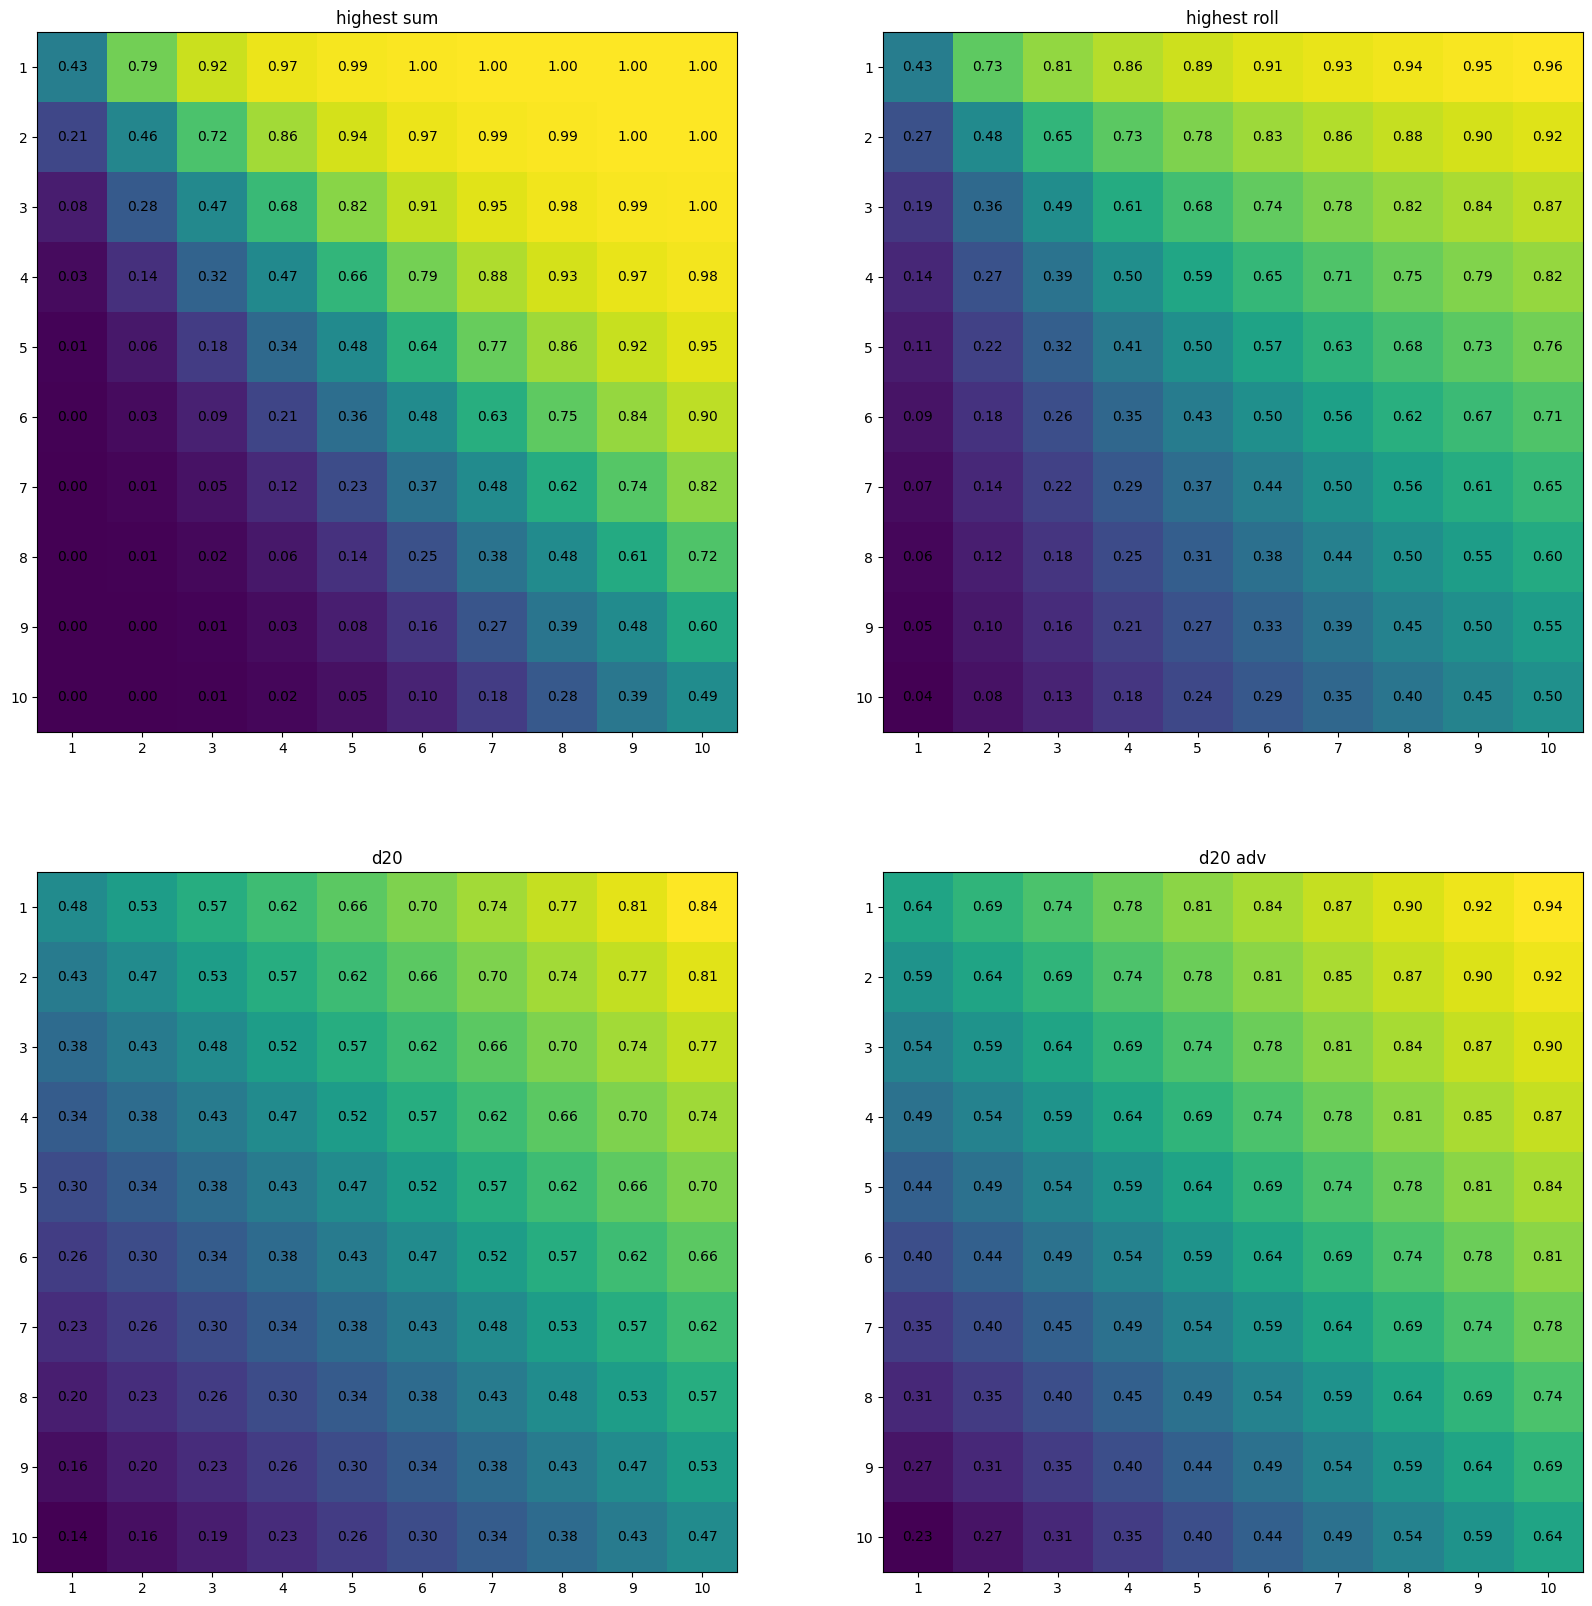

In [117]:
(attacker, defender) = np.split(rolls, 2, 1)

comparasons = {
    "highest sum": compare_rolls_adv(np.sum(attacker, axis=(0, 3)), np.sum(defender, axis=(0, 3))),
    "highest roll": compare_rolls_adv(
        # this works because (num_dice+1) ^ roll_result > num_dice * (num_dice+1) ^ (roll_result-1)
        # i.e. rolling higher once will beat rolling all dice with a result 1 less
        # need to take max_dice since A^0 = 1, and I don't want them affecting sum
        np.sum(np.full(attacker.shape, max_dice + 1) ** attacker - max_dice, axis=(0, 3)),
        np.sum(np.full(defender.shape, max_dice + 1) ** defender - max_dice, axis=(0, 3))
    ),
    "d20": compare_rolls(
        np.random.randint(1, 21, (int(trials/2), max_dice), dtype=np.uint8) + np.arange(max_dice, dtype=np.uint8),
        np.random.randint(1, 21, (int(trials/2), max_dice), dtype=np.uint8) + np.arange(max_dice, dtype=np.uint8)
    ),
    "d20 adv": compare_rolls(
        np.maximum(np.random.randint(1, 21, (int(trials/2), max_dice), dtype=np.uint8), np.random.randint(1, 21, (int(trials/2), max_dice), dtype=np.uint8)) + np.arange(max_dice, dtype=np.uint8),
        np.random.randint(1, 21, (int(trials/2), max_dice), dtype=np.uint8) + np.arange(max_dice, dtype=np.uint8)
    ),
    "risk": None # todo
}

fig, axs = plt.subplot_mosaic([
    ["highest sum", "highest roll"],
    ["d20", "d20 adv"],
])
fig.set_size_inches(20, 20)

for comp, ax in axs.items():
    ax.set_title(comp)
    ax.set_xticks(np.arange(comparasons[comp].shape[1]), labels=np.arange(comparasons[comp].shape[1]) + 1)
    ax.set_yticks(np.arange(comparasons[comp].shape[0]), labels=np.arange(comparasons[comp].shape[0]) + 1)


    for i in range(comparasons[comp].shape[1]):
        for j in range(comparasons[comp].shape[0]):
            ax.text(j, i, f"{comparasons[comp][i, j]:.2f}", ha="center", va="center")

    ax.imshow(comparasons[comp])

plt.show()
